<a href="https://colab.research.google.com/github/Jelius47/Data_sci_w_jelius/blob/main/Sentiment_analysis_Youtube_comments.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# YouTube Comments Summarization with OpenAI

In this notebook we harness the power of AI to deeply analyze YouTube comments and video transcripts.

1. Fetch Video Transcripts: Automatically retrieve the textual content of YouTube videos using the youtube-transcript-api.
2. Extract and Analyze Comments: Use the YouTube Data API to gather viewer comments from specified videos for further analysis.
3. Summarize and Link Comments to Transcripts: Apply OpenAI's GPT-3 model to summarize comments and correlate them with video transcripts, extracting meaningful insights that highlight viewer engagement and feedback.
4. Perform Sentiment Analysis: Utilize Hugging Face’s sentiment-analysis model to classify comments into positive, negative, or neutral categories, providing a quantitative measure of audience sentiment.
5. Visualize Data: Display sentiment analysis results using pie charts to give a visual representation of audience reactions.



## Setup
First, let's import necessary libraries and define our API keys and youtube video id.

Save the following three tokens in the secrets to be able to run this notebook:

1.   YT_APIKEY - Google API Key
2.   OPENAI_API_KEY - OpenAI API Key



In [ ]:
!pip install openai

from openai import OpenAI
from google.colab import userdata

# Instantiate OpenAI client (ensure your OpenAI API key is set in your environment variables or pass directly here).
client = OpenAI(
    api_key=userdata.get('OpenAi_API')
)

VIDEOID = 'i-txsBoTJtI'
GOOGLE_APIKEY = userdata.get('Youtbe_API')

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 312.9/312.9 kB 5.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 6.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 6.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 5.5 MB/s eta 0:00:00


## Fetching Youtube Video Transcription

In [ ]:
!pip install youtube-transcript-api

from youtube_transcript_api import YouTubeTranscriptApi

def get_video_transcript(video_id):
  try:
      # Fetching the transcript
      transcript = YouTubeTranscriptApi.get_transcript(video_id,  languages=['hi', 'en'])

      # Combine all text entries into a single string
      full_transcript = " ".join(entry['text'] for entry in transcript)
      return full_transcript
  except Exception as e:
      print(f"Failed to fetch transcript: {e}")
      return ""

def get_transcript_summary(transcript):
  response = client.chat.completions.create(
        model="gpt-3.5-turbo",
        messages=[
            {"role": "system", "content": "Provide a detailed summary of the given youtube video transcript."},
            {"role": "user", "content": transcript}
        ]
    )
  return response.choices[0].message.content

video_transcript = get_video_transcript(VIDEOID)
transcript_summary = get_transcript_summary(video_transcript)
print(transcript_summary)

The video is a tutorial by David Andre on how to build AI agents using the Llama Free model even with a low-performance computer and minimal programming knowledge. The tutorial walks through the process of setting up the environment using AMA to run the models locally, VS Code for coding, and Gro for optimal performance. The speaker demonstrates the speed of the models, showing 216 tokens per second. Different models like Llama 370b and the open-source model are compared, emphasizing the importance of leveraging AI technology. The tutorial encourages viewers to take the first step in building AI agents and provides a Workshop and community link for further learning. The speaker then starts building agents from scratch, guiding the audience through setting up the necessary tools, importing required packages, defining agents and tasks, and creating a team of agents for specific tasks such as email classification and response. The tutorial encounters some issues with the Llama Free model 

## Fetching YouTube Video Comments

In [ ]:
from googleapiclient.discovery import build

# Function to get YouTube comments
def get_comments(video_id, api_key):
    youtube = build('youtube', 'v3', developerKey=api_key)
    comments = []
    response = youtube.commentThreads().list(
        part="snippet",
        videoId=video_id,
        textFormat="plainText",
        maxResults=100
    ).execute()

    while response:
        for item in response['items']:
            comment = item['snippet']['topLevelComment']['snippet']['textDisplay']
            comments.append(comment)

        if 'nextPageToken' in response:
            response = youtube.commentThreads().list(
                part="snippet",
                videoId=video_id,
                pageToken=response['nextPageToken'],
                maxResults=100
            ).execute()
        else:
            break

    return comments

video_comments = get_comments(VIDEOID, GOOGLE_APIKEY)
print(video_comments)

["If you're serious about AI, and want to learn how to build Agents, join my community: https://www.skool.com/new-society", '0:05 "even if you have a bad computer"\n8:25 "look at the activity monitor" -> +20G in memory 😂', 'I am looking to create a local ai tool that will help me reword and spell and grammar check in UK brittish lanagugae that will run locally Windows?', 'Also, I fail to understand that eventually we have to use OPENAI as well!', 'The issue with these third parties is that there is lot under the hood and you will end with a lot of api calls and billing aspect is to be considered.', 'I came here because I am trying to fix all my LLMs not working well with functions using crewai. something up there I think. I have mistal, llama2 with crewai recommended modelfiles, and now tried llama3 your way. each of them fail with different issues trying to call functions.', "I don't understand the hate on some comments, this is top notch content! \nAnyway, I found it easier to run th

## Summarizing Comments
Summarize comments using OpenAI's GPT model.

In [ ]:
# Function to split comments into manageable batches
def batch_comments(comments, max_tokens=2048):
    batches = []
    current_batch = []
    current_length = 0

    for comment in comments:
        comment_length = len(comment.split())
        if current_length + comment_length > max_tokens:
            batches.append(current_batch)
            current_batch = [comment]
            current_length = comment_length
        else:
            current_batch.append(comment)
            current_length += comment_length

    if current_batch:
        batches.append(current_batch)

    return batches

# Function to get summaries from OpenAI
def get_comments_summaries(batches):
    summaries = []

    for batch in batches:
        response = client.chat.completions.create(
            model="gpt-3.5-turbo",
            messages=[
                {"role": "system", "content": "Summarize the following comments while keeping the detailed context."},
                {"role": "user", "content": " ".join(batch)}
            ]
        )
        print(response)
        summaries.append(response.choices[0].message.content)

    return summaries

# Function to create final summary from summaries
def create_final_summary(summaries, transcript_summary):
    summary_text = " ".join(summaries)
    response = client.chat.completions.create(
        model="gpt-3.5-turbo",
        messages=[
              {"role": "system", "content": f"This is the summary of a YouTube video's transcript: {transcript_summary}. A user has commented on the video. Your task is to analyze this comment in the context of the video transcript. Based on the comment content and its relation to the transcript, please provide detailed insights, addressing these key points:\n1. Identify positive aspects of the video that the comment highlights and link these to specific parts of the transcript where possible.\n2. Identify any criticisms or areas for improvement mentioned in the comment, and relate these to relevant sections of the transcript.\n3. Based on the feedback or suggestions in the comment, recommend new content ideas or topics for future videos that align with the viewer's interests and the overall content strategy but don't make up things from your side unnecessarily. Ensure your analysis is clear and includes specific examples from both the comment and the transcript to support your insights."},
              {"role": "user", "content": summary_text}
        ]
    )
    return response.choices[0].message.content

In [ ]:
batches = batch_comments(video_comments)
summaries = get_comments_summaries(batches)
final_comments_summary = create_final_summary(summaries, transcript_summary)
print(final_comments_summary)

ChatCompletion(id='chatcmpl-9LsmPUOgF7q2thyXPrtPXihy8aPne', choices=[Choice(finish_reason='stop', index=0, logprobs=None, message=ChatCompletionMessage(content='The user mentions creating a local AI tool for language modification and grammar checking, facing issues with LLMs and CrewAI, and highlights the importance of avoiding excessive API calls and billing concerns. They found it easier to run code with Grok by using ChatGroq and an .env file for API keys. They praise a tutorial that helped them, recommend switching to "dolphin-llama3" for better results, and mention difficulties with Tool usage in llama3. The user also expresses frustration with a purchased course, enjoys a tutorial despite encountering errors, asks about investing in GROQ, and seeks advice on crewai and openDevin tools. Additionally, they seek help with VS Code preferences and ask about PC requirements for running tools effectively. Overall, the user appreciates helpful content, expresses gratitude for support, an

## Sentiment analysis of comments

In [ ]:
def get_sentiments(comments):
    sentiment_counts = {'positive': 0, 'negative': 0, 'neutral': 0}

    for comment in comments:
        # Perform sentiment analysis on each comment individually
        try:
            sentiments = sentiment_analyzer(comment)
            # Assuming the first result is the relevant one if multiple are returned
            sentiment = sentiments[0] if isinstance(sentiments, list) and sentiments else None
        except Exception as e:
            print(f"Error in sentiment analysis: {e}")
            sentiment = None

        # Tally sentiments based on the analysis result
        if sentiment and sentiment['label'] == 'POSITIVE' and sentiment['score'] > 0.9:
            sentiment_counts['positive'] += 1
        elif sentiment and sentiment['label'] == 'NEGATIVE' and sentiment['score'] > 0.9:
            sentiment_counts['negative'] += 1
        else:
            sentiment_counts['neutral'] += 1

    return sentiment_counts

In [ ]:
# Function to plot the sentiment distribution
def plot_sentiment_distribution(sentiment_counts):
    labels = sentiment_counts.keys()
    sizes = sentiment_counts.values()
    colors = ['gold', 'lightcoral', 'lightskyblue']
    explode = (0.1, 0, 0)  # explode 1st slice

    plt.pie(sizes, explode=explode, labels=labels, colors=colors,
            autopct='%1.1f%%', shadow=True, startangle=140)

    plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
    plt.show()

No model was supplied, defaulted to distilbert/distilbert-base-uncased-finetuned-sst-2-english and revision af0f99b (https://huggingface.co/distilbert/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.


config.json:   0%|          | 0.00/629 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

Token indices sequence length is longer than the specified maximum sequence length for this model (762 > 512). Running this sequence through the model will result in indexing errors


Error in sentiment analysis: The size of tensor a (762) must match the size of tensor b (512) at non-singleton dimension 1
Error in sentiment analysis: The size of tensor a (588) must match the size of tensor b (512) at non-singleton dimension 1
Error in sentiment analysis: The size of tensor a (1107) must match the size of tensor b (512) at non-singleton dimension 1
Error in sentiment analysis: The size of tensor a (1206) must match the size of tensor b (512) at non-singleton dimension 1
Error in sentiment analysis: The size of tensor a (634) must match the size of tensor b (512) at non-singleton dimension 1
Error in sentiment analysis: The size of tensor a (1791) must match the size of tensor b (512) at non-singleton dimension 1
Error in sentiment analysis: The size of tensor a (1636) must match the size of tensor b (512) at non-singleton dimension 1


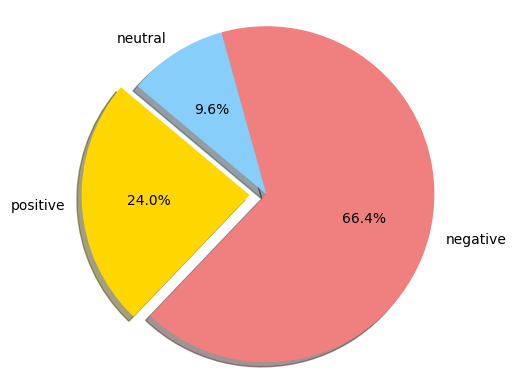

In [ ]:
!pip install transformers matplotlib

import matplotlib.pyplot as plt
from transformers import pipeline

# Initialize the sentiment-analysis pipeline
sentiment_analyzer = pipeline("sentiment-analysis")

sentiment_counts = get_sentiments(video_comments)
plot_sentiment_distribution(sentiment_counts)